In [1]:
import math
import numpy as np
import sympy as sym
import scipy.special
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp2d
%matplotlib inline
from scipy.integrate import cumtrapz

In [2]:
# n: number density
n=sym.symbols('n')

In [3]:
# rs: 3D Wigner-Seitz parameter
def n_from_rs(rs):
    return 3./(4*math.pi*rs*rs*rs) # 3D

In [4]:
### Exchange energy per particle
# Carsten A. Ullrich and Zeng-hui Yang, 
# A Brief Compendium of Time-Dependent Density Functional Theory 
# Braz J Phys (2014) 44:154–188, Eq.(34)
axfactor=-(3/4.)*(3/math.pi)**(1/3.)
def ex(n):
    return axfactor*n**(1/3.) # per particle

In [5]:
### Correlation: Chachiyo-Karasiev parametrization
acfactor=(math.log(2.)-1.)/(2.*math.pi**2)
n2invrs=(4.*math.pi/3)**(1/3.)
def ec(n):
    invrs = n2invrs*n**(1/3.) 
    return acfactor*sym.log( 1. + 21.7392245*invrs + 20.4562557*invrs**2 )

In [6]:
def exc(n):
    return ex(n)+ec(n)
np_exc=sym.lambdify(n, exc(n), 'numpy')

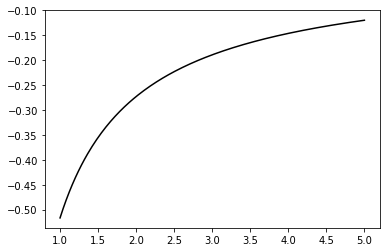

In [7]:
rsrange=np.linspace(1,5,200)
nrange=n_from_rs(rsrange)
fig,ax=plt.subplots()
ax.plot(rsrange,np_exc(nrange),'k')

In [8]:
f0=sym.diff(n*exc(n),n,2) # Eq.(i) GK
#finf=-(4/5.)*n**(2/3.)*sym.diff(exc(n)*n**(-2/3.)) # Eq.(ii) GK
finf=-(4/5.)*n**(2/3.)*sym.diff(exc(n)*n**(-2/3.)) + 6.*n**(1/3.)*sym.diff(exc(n)*n**(-1/3.)) # Eq.(2) Iwamoto
np_f0=sym.lambdify(n, f0, 'numpy')
np_finf=sym.lambdify(n, finf, 'numpy')
np_finf_f0=sym.lambdify(n, finf-f0, 'numpy')

In [9]:
gamma=math.gamma(1/4.)**2/math.sqrt(32*math.pi) # Eq.(17) GK+Errata

In [10]:
c=23*math.pi/15. # GK Eq.(13)

In [11]:
gamma_over_c = gamma/c # from Eq.(13) GK

In [12]:
def Imfxc(n,omega):
    a=-c*(gamma_over_c*np_finf_f0(n))**(5/3.) # GK Eq.(16)+Errata
    b=(gamma_over_c*np_finf_f0(n))**(4/3.) # GK Eq.(17)
    return a*omega/(1.+b*omega*omega)**(5/4.)

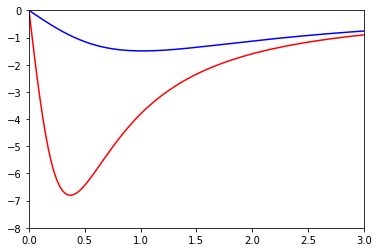

In [13]:
omegarange=np.linspace(0,5,200)
fig,ax=plt.subplots()
#ax.set_xlim([0,5]) # GK
#ax.set_ylim([-2.5,0]) # GK
ax.set_xlim([0,3])# Iwamoto
ax.set_ylim([-8,0]) # Iwamoto
ax.plot(omegarange,Imfxc(n_from_rs(2),omegarange),'b')
ax.plot(omegarange,Imfxc(n_from_rs(4),omegarange),'r')

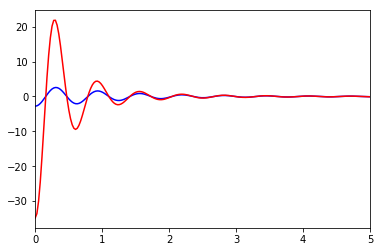

In [14]:
omegarange=np.linspace(0.0001,5,200)
tau=10
fig,ax=plt.subplots()
ax.set_xlim([0,5])
ax.plot(omegarange,Imfxc(n_from_rs(2),omegarange)*np.cos(omegarange*tau)/omegarange,'b')
ax.plot(omegarange,Imfxc(n_from_rs(4),omegarange)*np.cos(omegarange*tau)/omegarange,'r')

In [15]:
def integrand_without_cos(omega,n,tau):
    return Imfxc(n,omega)/omega

In [16]:
def cosintegral(n,tau):
    return 2.*quad(integrand_without_cos,1.e-10,math.inf,args=(n,tau),weight='cos',wvar=tau)[0]

In [17]:
n_from_rs(5)

0.0019098593171027439

In [18]:
n0=1.e-5
n0**(2/3)*cosintegral(n0,1)

-0.9574359368597054

In [19]:
#%timeit cosintegral(n_from_rs(4),1)

In [20]:
def KK_integrand(omega1,n):
    return Imfxc(n,omega1)

def Refxc(n,omega):
    #KKintegral=quad(KK_integrand,-500,500,args=(n,),limit=200,weight='cauchy',wvar=omega,points=[omega])[0]
    KKintegral=quad(KK_integrand,-1000,1000,args=(n,),limit=200,weight='cauchy',wvar=omega,points=[omega])[0]
    return np_finf(n)+KKintegral/math.pi

np_Refxc=np.vectorize(Refxc)

In [21]:
# ### Test: Fig.1 Iwamoto
# omegarange=np.linspace(0,5,20)
# fig,ax=plt.subplots()
# #ax.set_xlim([0,5]) # GK
# ax.set_xlim([0,3]) # Iwamoto
# ax.set_ylim([-17,0])
# ax.plot(omegarange,np_Refxc(n_from_rs(2),omegarange),'b.')
# ax.plot(omegarange,np_Refxc(n_from_rs(4),omegarange),'r.')

In [22]:
nexc2=sym.diff(n*exc(n),n,2)
np_nexc2=sym.lambdify(n, nexc2, 'numpy')

In [23]:
def muxc(n):
    return (3/4.)*n*n*(Refxc(n,0)-np_nexc2(n))

In [24]:
### ykernel: Y/n**2
def ykernel(n,tau):
#    return (3/4.)*(Refxc(n,0)-np_nexc2(n))-cosintegral(n,tau)/math.pi
    return -cosintegral(n,tau)/math.pi
np_y=np.vectorize(ykernel)

In [25]:
Y0=-(20/3.)*n*exc(n)+(26/5.)*n*sym.diff(n*exc(n))-n*n*sym.diff(n*exc(n),n,2)
np_Y0=sym.lambdify(n, Y0, 'numpy')

In [26]:
np_Y0(n_from_rs(4))

0.00016748743915599284

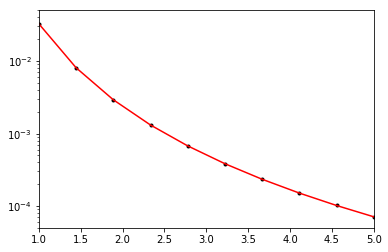

In [27]:
rsrange=np.linspace(1,5,10)
nrange=n_from_rs(rsrange)
fig,ax=plt.subplots()
ax.set_xlim([1,5])
ax.set_ylim([5e-5,5e-2])
ax.semilogy(rsrange,nrange**2*np_y(nrange,0),'k.')
ax.semilogy(rsrange,np_Y0(nrange),'r')

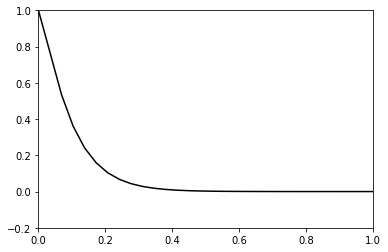

In [28]:
def Tp(n):
    omegap=math.sqrt(4.*math.pi*n)
    return 2.*math.pi/omegap
    #return 0.5*2.*math.pi/omegap # agrees better ???

rs0=5.
n0=n_from_rs(rs0)
tau=np.linspace(0.,Tp(n0),30)
fig,ax=plt.subplots()
ax.set_xlim(0,1)
ax.set_ylim(-0.2,1)
ax.plot(tau/Tp(n0),np_y(n0,tau)/np_y(n0,0),'k');

## 2QWell

In [29]:
N=1.; L=10.; avomp=math.sqrt(32*N/(math.pi*L)); # Eq.(57) Ullrich

In [30]:
A=0.005; omega=2.22*avomp; T=2*math.pi/omega;

In [31]:
def v(xi,t):
    return A*omega*xi*np.cos(omega*t)

def gradv(t):
    return A*omega*np.cos(omega*t)

def g1(t):
    return (np.sin(omega*t/2)**2)
def g2(t):
    return (np.cos(omega*t/2)**2)
def g_dif1(t):
    return (np.sin(omega*t/2)*2*np.cos(omega*t/2)*omega/2)
def g_dif2(t):
    return -np.cos(omega*t/2)*2*np.sin(omega*t/2)*omega/2
def f1(x):
    return np.exp(-(x-3)**2)
def f2(x):
    return np.exp(-(x-6)**2)
def nr(x,t):
    return f1(x)*g1(t)+f2(x)*g2(t)

# def nbreather(x,t):
#     sqrtavg=1./(1+A*np.sin(omega*t))
#     if abs(x)<=(L/2.)*(1+A*np.sin(omega*t)):
#         return (2.*N/L)*sqrtavg*np.cos(sqrtavg*math.pi*x/L)**2
#     else:
#         return 0.

# x -- 1D numpy array
def nbreather(x,t):
    return f1(x)*g1(t)+f2(x)*g2(t)

In [32]:
x = np.linspace(0, 9, 50)
def f_dif1(x):
    return -2*(x-3)*np.exp(-(x-3)**2)
def f_dif2(x):
    return -2*(x-6)*np.exp(-(x-6)**2)
y=f1(x)
y2=f2(x)


In [33]:
h=x[1]-x[0]

In [34]:
def B2(t):
    return cumtrapz(y, x, initial=0)*g_dif1(t)+cumtrapz(y2, x,  initial=0)*g_dif2(t)
def v(t):
   
    return -B2(t)/(y*g1(t)+y2*g2(t))

In [35]:
def a(t):
    return y*g1(t)+y2*g2(t)
y_dif=f_dif1(x)
y2_dif=f_dif2(x)
def v_dif(t):
    return -1/a(t)*(y*g_dif1(t)+y2*g_dif2(t))+(y_dif*g1(t)+y2_dif*g2(t))/a(t)/a(t)*B2(t)
def gradv(t):
    return v_dif(t)


1

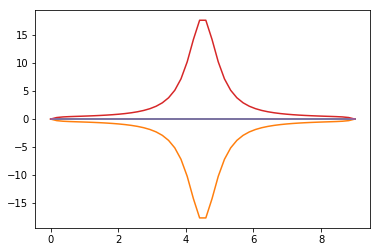

In [36]:
nmax=1
x = np.linspace(0, 9, 50)
xrange=np.linspace(0,9,400)
fig,ax=plt.subplots()
#ax.set_xlim([-(1+A)*L/2,(1+A)*L/2])
#ax.set_ylim([0,nmax])
ax.plot(x,v(0*T/4))
ax.plot(x,v(1*T/4))
ax.plot(x,v(2*T/4))
ax.plot(x,v(3*T/4))
ax.plot(x,v(4*T/4))
nmax

1

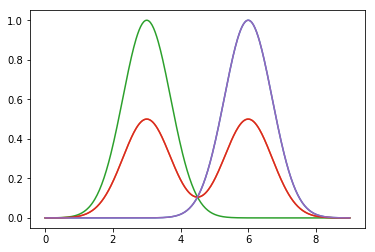

In [37]:
nmax=1
xrange=np.linspace(0,9,400)
fig,ax=plt.subplots()
#ax.set_xlim([-(1+A)*L/2,(1+A)*L/2])
#ax.set_ylim([0,nmax])
ax.plot(xrange,nbreather(xrange,0*T/4))
ax.plot(xrange,nbreather(xrange,1*T/4))
ax.plot(xrange,nbreather(xrange,2*T/4))
ax.plot(xrange,nbreather(xrange,3*T/4))
ax.plot(xrange,nbreather(xrange,4*T/4))
nmax

In [38]:
nrange=np.linspace(1.e-8,1,200)
trange=np.linspace(0.,T,10)
nnrange,ttrange = np.meshgrid(nrange,trange,indexing='xy')

In [39]:
%time ydata=np_y(nnrange,ttrange)

CPU times: user 9.13 s, sys: 36.7 ms, total: 9.17 s
Wall time: 9.22 s


In [40]:
yint=interp2d(nrange, trange, ydata, kind='cubic')

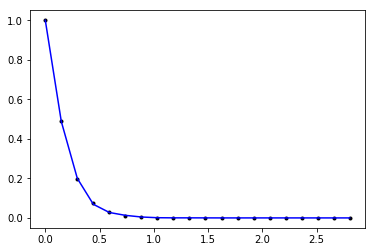

In [41]:
n0=1
tau=np.linspace(0.,T,20)
fig,ax=plt.subplots()
#ax.set_xlim(0,1)
#ax.set_ylim(-0.2,1)
ax.plot(tau,np_y(n0,tau)/np_y(n0,0),'k.');
ax.plot(tau,yint(n0,tau)/yint(n0,0),'b');

In [42]:
yint(nbreather(1*h,2),2-1)

array([48117.84518561])

In [43]:
### sxc = sigma_xc/n**2
def sxc_integrand(t1,t,k):
    return yint(nbreather(k*h,t),t-t1)*gradv(t1)[k]

def sxc(t,k):
    return quad(sxc_integrand,0,t,args=(t,k))[0]

np_sxc=np.vectorize(sxc)

In [44]:
sxc_0=np.zeros((50))
for n in range (0,50):
    sxc_0[n]= (sxc(2*T+0*T/4,n))
sxc_1=np.zeros((50))
for n in range (0,50):
    sxc_1[n]= (sxc(2*T+T/4,n))
sxc_2=np.zeros((50))
for n in range (0,50):
    sxc_2[n]= (sxc(2*T+2*T/4,n))
sxc_3=np.zeros((50))
for n in range (0,50):
    sxc_3[n]= (sxc(2*T+3*T/4,n))
sxc_4=np.zeros((50))
for n in range (0,50):
    sxc_4[n]= (sxc(2*T+4*T/4,n))    

/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and 

In [45]:
def n_dif(x,t):
    return f_dif1(x)*g1(t)+f_dif2(x)*g2(t)
nd_0=np.zeros((50))
for n in range (0,50):
    nd_0[n]=n_dif(x[n],2*T+0*T/4)
nd_1=np.zeros((50))
for n in range (0,50):
    nd_1[n]=n_dif(x[n],2*T+1*T/4)
nd_2=np.zeros((50))
for n in range (0,50):
    nd_2[n]=n_dif(x[n],2*T+2*T/4)
nd_3=np.zeros((50))
for n in range (0,50):
    nd_3[n]=n_dif(x[n],2*T+3*T/4) 
nd_4=np.zeros((50))
for n in range (0,50):
    nd_4[n]=n_dif(x[n],2*T+4*T/4)     
    
    
    
n_0=np.zeros((50))
for n in range (0,50):
    n_0[n]=nbreather(x[n],2*T+0*T/4)
n_1=np.zeros((50))
for n in range (0,50):
    n_1[n]=nbreather(x[n],2*T+1*T/4)
n_2=np.zeros((50))
for n in range (0,50):
    n_2[n]=nbreather(x[n],2*T+2*T/4)
n_3=np.zeros((50))
for n in range (0,50):
    n_3[n]=nbreather(x[n],2*T+3*T/4) 
n_4=np.zeros((50))
for n in range (0,50):
    n_4[n]=nbreather(x[n],2*T+4*T/4)     
        
    


In [46]:
n_3

array([6.17049020e-05, 1.79588523e-04, 4.88579029e-04, 1.24247711e-03,
       2.95351584e-03, 6.56277543e-03, 1.36311694e-02, 2.64652511e-02,
       4.80304059e-02, 8.14805280e-02, 1.29207810e-01, 1.91523071e-01,
       2.65369473e-01, 3.43699393e-01, 4.16107675e-01, 4.70907404e-01,
       4.98171864e-01, 4.92685778e-01, 4.55625576e-01, 3.94270368e-01,
       3.19910485e-01, 2.44893248e-01, 1.80002588e-01, 1.33008724e-01,
       1.08505796e-01, 1.08505796e-01, 1.33008724e-01, 1.80002588e-01,
       2.44893248e-01, 3.19910485e-01, 3.94270368e-01, 4.55625576e-01,
       4.92685778e-01, 4.98171864e-01, 4.70907404e-01, 4.16107675e-01,
       3.43699393e-01, 2.65369473e-01, 1.91523071e-01, 1.29207810e-01,
       8.14805280e-02, 4.80304059e-02, 2.64652511e-02, 1.36311694e-02,
       6.56277543e-03, 2.95351584e-03, 1.24247711e-03, 4.88579029e-04,
       1.79588523e-04, 6.17049020e-05])

In [47]:
#nrange=np.linspace(1.e-8,nmax,200)
#trange=np.linspace(2*T,3*T,50)
#nnrange,ttrange = np.meshgrid(nrange,trange,indexing='xy')
#%time sxcdata=np_sxc(nnrange,ttrange,m)

In [48]:
#sxcint=interp2d(nrange, trange, sxcdata, kind='cubic')

In [49]:
#n0=nmax
#tvals=np.linspace(0.,5*T,200)
#fig,ax=plt.subplots()
#ax.plot(tvals,np_sxc(n0,tvals),'r');
#ax.plot(tvals,sxcint(n0,tvals),'k',ls='dashed');

In [50]:
#nvals=np.linspace(1.e-5,0.05,200)
#fig,ax=plt.subplots()
#ax.set_xlim([0.,nmax])
#ax.set_ylim([-0.005,0.005])
#ax.plot(nvals,np_sxc(nvals,2*T+3*T/4.)*nvals**(2/3.),'k.');
#ax.plot(nvals,sxcint(nvals,2*T+3*T/4.)*nvals**(2/3.),'r');

In [51]:
from scipy.integrate import simps

I_0 = cumtrapz(nd_0*sxc_0, x, initial=0)
I_1 = cumtrapz(nd_1*sxc_1, x, initial=0)
I_2 = cumtrapz(nd_2*sxc_2, x, initial=0)
I_3 = cumtrapz(nd_3*sxc_3, x, initial=0)
I_4 = cumtrapz(nd_4*sxc_4, x, initial=0)

In [52]:
I_1

array([   0.        , -165.20127749, -193.47381468, -214.90758785,
       -184.89940623, -153.36036791, -157.70748813, -152.86344115,
       -153.26249624, -153.29172058, -153.32424218, -153.33985907,
       -153.35637294, -153.37262219, -153.3874211 , -153.39930153,
       -153.40594134, -153.40318251, -153.38353584, -153.33462542,
       -153.24044821, -153.09390621, -152.92899865, -152.83517521,
       -152.84527138, -152.82791708, -152.69136696, -152.51658827,
       -152.38547969, -152.30752124, -152.2664787 , -152.24709241,
       -152.23964187, -152.23860326, -152.24093728, -152.24496443,
       -152.24972373, -152.25461497, -152.25919488, -152.26307145,
       -152.26589925, -152.2674291 , -152.2616112 , -152.34064017,
       -152.22077505, -152.37587919, -153.26421425, -154.50630198,
       -156.18008824, -158.34543184])

In [53]:
#def Vxc_integrand(n,t):
 #   return sxcint(n,t)

#def Vxc(n,t):
 #   return -n*sxcint(n,t) - quad(Vxc_integrand,1.e-8,n,args=(t,))[0]

#np_Vxc=np.vectorize(Vxc)

V_0=(-n_0*sxc_0-I_0)/n_0/n_0
V_1=(-n_1*sxc_0-I_1)/n_1/n_1
V_2=(-n_2*sxc_2-I_2)/n_2/n_2
V_3=(-n_3*sxc_3-I_3)/n_3/n_3
V_4=(-n_4*sxc_3-I_4)/n_4/n_4

In [54]:
V_3

array([1.84507800e+10, 3.78084521e+09, 6.26810436e+08, 1.09071250e+08,
       6.47366236e+06, 2.10067555e+06, 5.58717444e+05, 1.39701939e+05,
       4.26120100e+04, 1.48059826e+04, 5.88760700e+03, 2.67940961e+03,
       1.39552955e+03, 8.31835948e+02, 5.67455181e+02, 4.43007937e+02,
       3.95778989e+02, 4.04561961e+02, 4.72937266e+02, 6.31395875e+02,
       9.58688197e+02, 1.63534929e+03, 3.02595466e+03, 5.54158238e+03,
       8.33421777e+03, 8.36136356e+03, 5.59481542e+03, 3.06974808e+03,
       1.66272975e+03, 9.74966819e+02, 6.41687217e+02, 4.80225291e+02,
       4.10463494e+02, 4.01276613e+02, 4.48902462e+02, 5.74720542e+02,
       8.42115362e+02, 1.41220516e+03, 2.71040922e+03, 5.95366602e+03,
       1.49702142e+04, 4.30616911e+04, 1.41976582e+05, 5.27011611e+05,
       2.30474847e+06, 1.19703854e+07, 6.65407996e+07, 3.64264667e+08,
       3.01686760e+09, 2.94751102e+10])

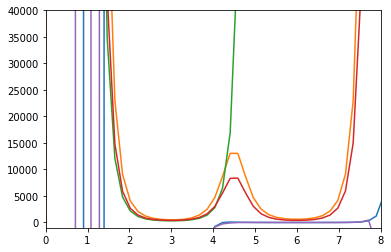

In [57]:
nmax=1
x = np.linspace(0, 9, 50)
xrange=np.linspace(0,9,400)
fig,ax=plt.subplots()
ax.set_xlim([0,8])
ax.set_ylim([-1000,40000])
ax.plot(x,V_0)
ax.plot(x,V_1)
ax.plot(x,V_2)
ax.plot(x,V_3)
ax.plot(x,V_4)
